Setting up AI model...
Using device: cpu
Model 'wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M' loaded and ready.

Processing image: /mnt/c/Users/ogw/Downloads/fox4.png


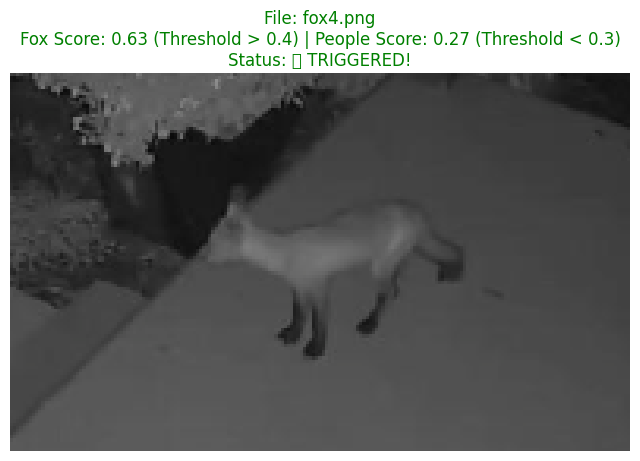

Finished.
man 0.06780678778886795
woman 0.02760276198387146
a person walking 0.01722792722284794
a photograph of a person 0.1309238076210022
people 0.019363785162568092
person wearing a jumper 0.008475779555737972
a photograph of a fox 0.6261352896690369
a photograph of a frog 0.08944301307201385
an empty garden at night 0.0048646642826497555
a car 0.00815623253583908


In [36]:
# ==============================================================================
# 1. IMPORTS AND INITIAL SETUP
# ==============================================================================
import os
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import matplotlib.pyplot as plt

# ==============================================================================
# 2. TINYCLIP MODEL SETUP
# ==============================================================================
# --- Configuration ---
MODEL_ID = "wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M"

# --- Device Selection ---
print("Setting up AI model...")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Load Model and Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
model.to(DEVICE)
model.eval()
print(f"Model '{MODEL_ID}' loaded and ready.")

# ==============================================================================
# 3. DETECTION ALGORITHM CONFIGURATION
# ==============================================================================
# --- Prompts ---
n_people_decoys = 6
PROMPTS = [
    "man", "woman", "a person walking", "a photograph of a person",
    "people", "person wearing a jumper", "a photograph of a fox",
    "a photograph of a frog", "an empty garden at night", "a car"
]
FOX_PROMPT_INDEX = PROMPTS.index("a photograph of a fox")

# --- Thresholds ---
FOX_SCORE_THRESHOLD = 0.40
PEOPLE_SUM_THRESHOLD = 0.30

# ==============================================================================
# 4. HELPER FUNCTIONS
# ==============================================================================
def score_image_against_prompts(image_frame, prompts):
    """Scores an image (NumPy array) against a list of text prompts."""
    rgb_frame = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(rgb_frame)
    
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1).squeeze().cpu().numpy()
        
    return probs

def display_image_with_results(image_frame, file_path, fox_score, people_score, is_triggered):
    """Displays the image inline with its scores and trigger status in the title."""
    rgb_image = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    
    status_text = "✅ TRIGGERED!" if is_triggered else "❌ NOT TRIGGERED"
    title_color = 'green' if is_triggered else 'red'
    
    title = (
        f"File: {os.path.basename(file_path)}\n"
        f"Fox Score: {fox_score:.2f} (Threshold > {FOX_SCORE_THRESHOLD}) | "
        f"People Score: {people_score:.2f} (Threshold < {PEOPLE_SUM_THRESHOLD})\n"
        f"Status: {status_text}"
    )
    
    plt.imshow(rgb_image)
    plt.title(title, color=title_color, fontsize=12)
    plt.axis('off')
    plt.show()

# ==============================================================================
# 5. MAIN EXECUTION LOGIC
# ==============================================================================
def test_single_image(image_path):
    """
    Loads a single image and runs the fox detection algorithm on it.
    """
    print(f"\nProcessing image: {image_path}\n" + "="*50)
    
    if not os.path.exists(image_path):
        print(f"⚠️ ERROR: The file was not found at '{image_path}'. Please check the path.")
        return

    image_frame = cv2.imread(image_path)
    if image_frame is None:
        print(f"Could not read the image file. Please check if it's a valid image.")
        return

    # Get the probability scores from the model.
    probabilities = score_image_against_prompts(image_frame, PROMPTS)
    
    # Extract the specific scores for the algorithm.
    fox_score = probabilities[FOX_PROMPT_INDEX]
    people_scores_sum = np.sum(probabilities[:n_people_decoys])
    
    # Determine if the trigger conditions are met.
    is_triggered = (fox_score > FOX_SCORE_THRESHOLD and 
                    people_scores_sum < PEOPLE_SUM_THRESHOLD)
    
    # Display the image and the results.
    display_image_with_results(image_frame, image_path, fox_score, people_scores_sum, is_triggered)
    
    print("="*50 + "\nFinished.")

    for thing, prob in zip(PROMPTS, probabilities):
        print(f"{thing} {prob}")

# ==============================================================================
# 6. RUN THE TEST
# ==============================================================================
if __name__ == '__main__':
    # --- IMPORTANT: EDIT THIS PATH ---
    # Point this to the single image file you want to test.
    # 🦊 EXAMPLE for Windows: IMAGE_PATH_TO_TEST = r"C:\Users\YourUsername\Desktop\fox.jpg"
    # 🦊 EXAMPLE for Mac/Linux: IMAGE_PATH_TO_TEST = "/home/your_username/pictures/fox.jpg"
    
    IMAGE_PATH_TO_TEST = r"/mnt/c/Users/ogw/Downloads/fox4.png"
    
    test_single_image(IMAGE_PATH_TO_TEST)